In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import os
pd.set_option('display.max_columns', None)

# choose directory which stores the file 'aggregated_tsv.tsv'
input_dir = '/home/eligol/Documents/01_WIS/01_Rarevar/data/outputs/statistics_output/human_RSS9451/'


# human DB files
rep_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/human/edit_rep.bed'
non_rep_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/human/edit_nonrep.bed'
snp_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/human/snp_chr_sorted.vcf'

# Yotam filtered for UTR3
# rep_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/Yotam_filtered/edit_rep.bed'
# non_rep_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/Yotam_filtered/edit-nonrep-exonic_UTR3.bed'
# snp_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/Yotam_filtered/snps_exonic_UTR3.vcf'

# original DB files
# rep_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/edit_rep.bed'
# non_rep_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/edit_nonrep.bed'
# snp_db_path = '/home/eligol/Documents/01_WIS/01_Rarevar/data/DB_edit_snp/C57BL_6NJ.mgp.v5.snps.dbSNP142.pass.chr.vcf'

agg_df_path = os.path.join(input_dir, 'aggregated_tsv.tsv')
snp_temp = os.path.join(input_dir ,'snp_intersect.tsv')
edit_temp = os.path.join(input_dir ,'edit_intersect.tsv')
df_intersection = os.path.join(input_dir ,'aggregated_intersect.tsv')

# Find intersections with edit and snp databases

In [7]:
%%bash -s "$agg_df_path" "$snp_db_path" "$snp_temp" "$rep_db_path" "$edit_temp" "$non_rep_db_path" "$df_intersection"

module load bedtools
head -c 1 $1 | grep -q '#' || sed -i '1s/^/#/' $1 # add '#' to header of df_aggregated
#### both files must be sorted if you use '-sorted' which reduce memoty usage
bedtools intersect -a $1 -b $2 -c -header -sorted > $3 # find intersection with snp db
sed -i '1 s/.*/&\tis_snp/' $3 # add column name 'is_snp'

bedtools intersect -a $3 -b $4 -c -header > $5
sed -i '1 s/.*/&\tis_editing_rep/' $5

bedtools intersect -a $5 -b $6 -c -header > $7
sed -i '1 s/.*/&\tis_editing_non_rep/' $7

rm $3 $5

bash: line 2: module: command not found


# Venn diagram

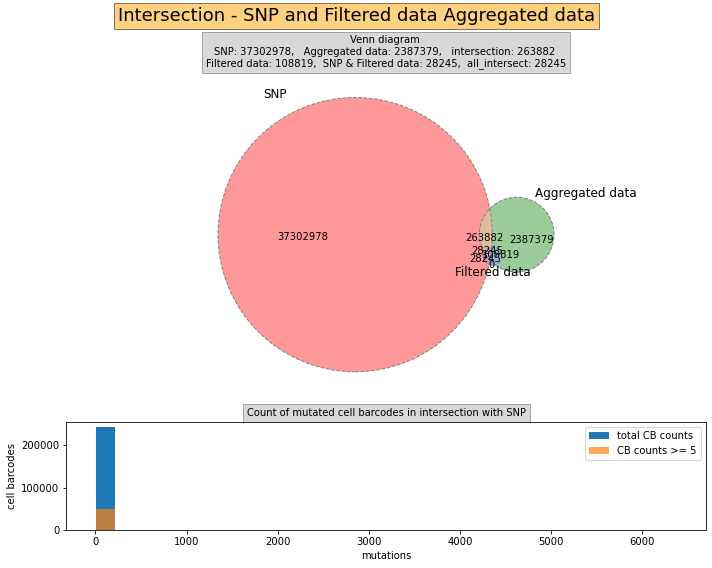

<Figure size 432x288 with 0 Axes>

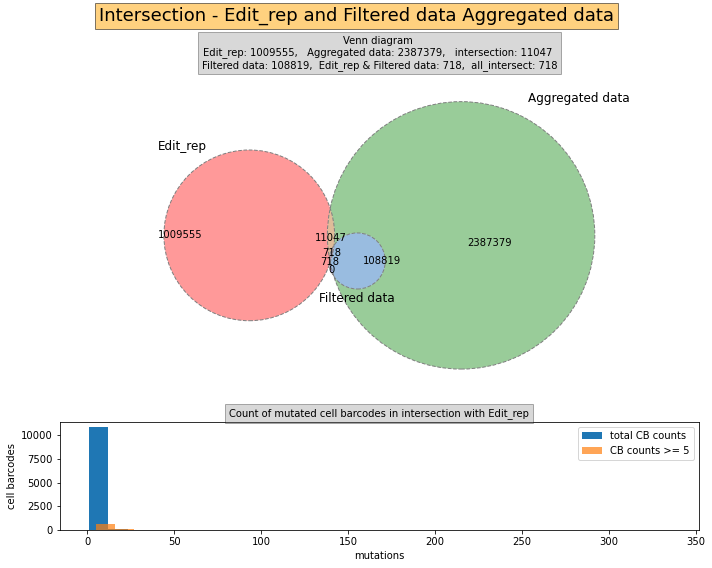

<Figure size 432x288 with 0 Axes>

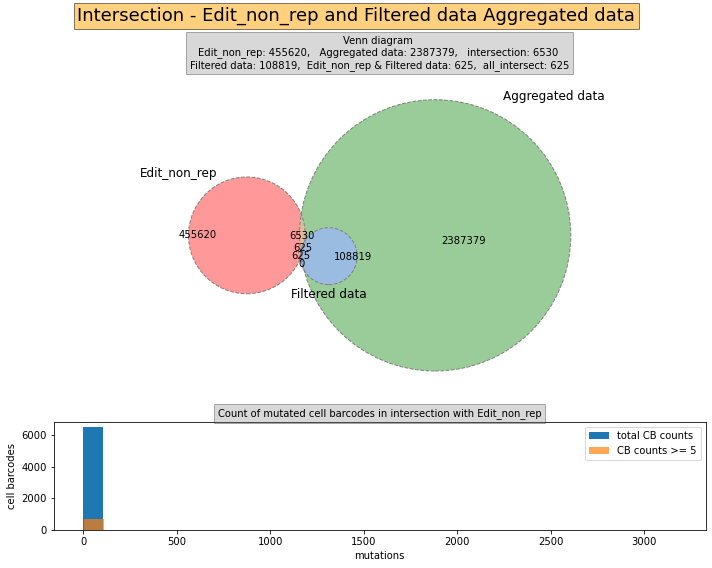

<Figure size 432x288 with 0 Axes>

In [8]:
def make_venn_diagram(df, subset_list, labels,column_name):

    fig, axs = plt.subplots(2, figsize = (10,8),gridspec_kw={'height_ratios': [3,1]})
    fig.suptitle('Intersection - {} and {} {}'.format(labels[0],labels[2],labels[1]),
                 fontsize=18,bbox={"facecolor":"orange", "alpha":0.5})
    axs[0].set_title("Venn diagram \n{a}: {b},   {c}: {d},   {e}: {f} \n{g}: {h},  {i}: {j},  {k}: {l}".format(
        a = labels[0],b=subset_list[0], 
        c = labels[1], d= subset_list[1],
        e = "intersection",f=subset_list[2],
        g = labels[2], h = subset_list[5] + subset_list[3],
        i = labels[0]+" & "+labels[2], j = subset_list[4],
        k = "all_intersect", l = subset_list[6]), fontsize=10,bbox={"facecolor":"gray", "alpha":0.3})
    
    v = venn3(subsets=subset_list, set_labels = (labels[0], labels[1], labels[2]),ax=axs[0])
    venn3_circles(subsets=subset_list,color = 'gray',linewidth = 1, linestyle = 'dashed',ax=axs[0])
    
    # make histogram of mutated CB
    intrsct_list = df[df[column_name] == 1]['count of mutated cell barcodes']
    axs[1].hist(intrsct_list,bins=30)
    axs[1].hist([i for i in intrsct_list if i >= 5],bins=30, alpha = 0.7)
    axs[1].set_title("Count of mutated cell barcodes in intersection with {}".format(labels[0]), fontsize=10,bbox={"facecolor":"gray", "alpha":0.3})
    axs[1].set_xlabel("mutations")
    axs[1].set_ylabel("cell barcodes")
    axs[1].legend(['total CB counts', 'CB counts >= 5'])
    fig.tight_layout()

    plt.savefig(os.path.join(input_dir, 'venn_diagram_{}.png'.format(labels[0])),facecolor = 'white')
    plt.show()
    plt.clf()

    
def run_venn(df, column_name, db_total_count , labels):
    df_filtered = df[(df['count of mutated cell barcodes'] >= 5) & (df['count of unmutated cell barcodes'] >= 1)]
    df_pos_count = df.shape[0]
    filtered_df_intrsct = len(df.index & df_filtered.index)
    filtered_count = df_filtered.shape[0] - filtered_df_intrsct
    db_df_intrsct = df[column_name].sum()
    db_filtered_intrsct = df_filtered[column_name].sum()
    db_filtered_df_intrsct = df_filtered[column_name].sum()
    
    intersection_list = [db_total_count, df_pos_count, db_df_intrsct,
                         filtered_count, db_filtered_intrsct, filtered_df_intrsct,
                         db_filtered_df_intrsct]    
    make_venn_diagram(df, intersection_list, labels, column_name)

    
    
# count lines in databases files
snp_total_count = !grep -v '#' {snp_db_path} | wc -l  # count lines without headers
snp_total_count = int(snp_total_count.pop())
edit_rep_total_count = !cat {rep_db_path} | wc -l
edit_rep_total_count = int(edit_rep_total_count.pop())
edit_nonrep_total_count = !cat {non_rep_db_path} | wc -l
edit_nonrep_total_count = int(edit_nonrep_total_count.pop())

# read the df
df_agg_intrsct = pd.read_csv(df_intersection, sep = '\t')

# make Venn diagrams for snp, editting rep and editting non_rep intersections
run_venn(df_agg_intrsct, 'is_snp',snp_total_count,['SNP', 'Aggregated data','Filtered data'])
run_venn(df_agg_intrsct, 'is_editing_rep',edit_rep_total_count,['Edit_rep', 'Aggregated data','Filtered data'])
run_venn(df_agg_intrsct, 'is_editing_non_rep',edit_nonrep_total_count,['Edit_non_rep', 'Aggregated data','Filtered data'])

In [18]:

df_agg_intrsct.loc[df_agg_intrsct['is_snp'] > 0, 'is_snp'] = 1
df_agg_intrsct['is_snp'].value_counts()
df_agg_intrsct.columns

Index(['#Chromosome', 'start', 'end', 'position',
       'percent of non ref total umis', 'strand',
       'count of unmutated cell barcodes', 'count of mutated cell barcodes',
       'percent of non ref mutated umis', 'reference base', 'R->A multi reads',
       'R->T multi reads', 'R->G multi reads', 'R->C multi reads',
       'R->A single reads', 'R->T single reads', 'R->G single reads',
       'R->C single reads', 'mixed reads', 'total mutation umi count',
       'unmutated single reads', 'unmutated multi reads',
       'aggregated cell barcodes', 'total umi counts 1 cells',
       'median percent of non ref umi 1 cells', 'total umi counts 2 cells',
       'median percent of non ref umi 2 cells', 'total umi counts 3 cells',
       'median percent of non ref umi 3 cells', 'total umi counts 4+ cells',
       'median percent of non ref umi 4+ cells', 'is_snp', 'is_editing_rep',
       'is_editing_non_rep'],
      dtype='object')

## count overlaps between original bam file and edditing/snp DB

In [9]:
orig_bam_file = "/run/user/1000/gvfs/smb-share:server=data.wexac.weizmann.ac.il,share=bioservices/shared/rarevar/data/bam_files/filtered_bam_files/mice_PP_htseq/micePP_merged_chr___filtered_gene.bam"

overlap_rep = !bedtools intersect -sorted -u -a {rep_db_path} -b {orig_bam_file}
overlap_non_rep = !bedtools intersect -sorted -u -a {non_rep_db_path} -b {orig_bam_file}
overlap_snp = !bedtools intersect -sorted -u -a {snp_db_path} -b {orig_bam_file}

In [10]:
# [eligol@bio mice_PP_htseq]$ bedtools coverage -counts -a /home/labs/bioservices/shared/rarevar/TEST_bam_filter_outputs/edit-nonrep-exonic_UTR3.bed -b micePP_merged_chr___filtered_gene.bam > coverage.txt

my_file = open("/run/user/1000/gvfs/smb-share:server=data.wexac.weizmann.ac.il,share=bioservices/shared/rarevar/data/bam_files/filtered_bam_files/mice_PP_htseq/coverage.txt", "r")
content_list = my_file.readlines()
my_file.close()

FileNotFoundError: [Errno 2] No such file or directory: '/run/user/1000/gvfs/smb-share:server=data.wexac.weizmann.ac.il,share=bioservices/shared/rarevar/data/bam_files/filtered_bam_files/mice_PP_htseq/coverage.txt'

In [ ]:
t = [l.split("\t")[1] for l in overlap_non_rep]
t2 = [l.split("\t")[1] for l in content_list if (int(l.split("\t")[-1]) != 0)]

set(t2) - set(t)

In [ ]:
# df_agg_intrsct[df_agg_intrsct['is_snp'] == 1]
# df_agg_intrsct[df_agg_intrsct.duplicated(subset = 'start', keep = False)]
# df[df['count of mutated cell barcodes'] >= 5]
df_agg_intrsct[(df_agg_intrsct['is_editing_non_rep'] == 1) & (df_agg_intrsct['count of mutated cell barcodes'] >= 5)]
df_agg_intrsct[(df_agg_intrsct['is_editing_non_rep'] == 1) & (df_agg_intrsct['count of mutated cell barcodes'] >= 1)]